In [170]:
import torch
import time
import numpy as np
import subprocess
import yaml
from itertools import product
import random
import math
import matplotlib.pyplot as plt

In [97]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [116]:
def get_power_limit():
    result = subprocess.run(["nvidia-smi", "--query-gpu=power.limit"], capture_output=True, text=True)
    return float(result.stdout.split('\n')[1].split()[0])

def get_sm_clock():
    result = subprocess.run(["nvidia-smi", "--query-gpu=clocks.max.sm"], capture_output=True, text=True)
    return float(result.stdout.split('\n')[1].split()[0])    

In [117]:
get_sm_clock()

2100.0

In [100]:
with open("sm_cores.yaml", "r") as file:
    sm_cores = yaml.safe_load(file)

sm_cores

{'cuda_cores_per_sm': {'2.0': 32,
  '2.1': 48,
  '3.0': 192,
  '3.2': 192,
  '3.5': 192,
  '3.7': 192,
  '5.0': 128,
  '5.2': 128,
  '5.3': 128,
  '6.0': 64,
  '6.1': 128,
  '6.2': 128,
  '7.0': 64,
  '7.2': 64,
  '7.5': 64,
  '8.0': 128,
  '8.6': 128,
  '8.9': 128,
  '9.0': 128}}

In [123]:
props = torch.cuda.get_device_properties(0)

device_information = {
    "device_name": torch.cuda.get_device_name(0),
    "number_of_sm": props.multi_processor_count,
    "power_limit": get_power_limit(),
    "compute_capability": (props.major, props.minor),
    "cores_per_sm": sm_cores['cuda_cores_per_sm'][f"{props.major}.{props.minor}"],
    "sm_clock": get_sm_clock()
}
device_information["total_number_of_cores"] = device_information["number_of_sm"] * device_information["cores_per_sm"]
device_information["theoretical_flops"] = device_information["total_number_of_cores"] * device_information["sm_clock"] * 2 * 1e6
device_information['theoretical_flops'] / 1e12

24.7296

### Measure flops using events

In [132]:
def benchmark_gemm(M, N, K, device, dtype, n_warmup, n_repeat):
    A = torch.rand(M, N, device = device, requires_grad=False, dtype = dtype)
    B = torch.rand(N, K, device = device, requires_grad=False, dtype = dtype)
    C = torch.rand(M, K, device = device, requires_grad=False, dtype = dtype)
    total_time = np.empty((n_repeat))
    flops = np.empty((n_repeat))
    start = torch.cuda.Event(enable_timing = True)
    end = torch.cuda.Event(enable_timing = True)
    
    for i in range(n_warmup):
        torch.mm(A, B, out=C)
        
    for i in range(n_repeat):    
        start.record()
        torch.mm(A, B, out=C)
        end.record()
        torch.cuda.synchronize()
        total_time[i] = start.elapsed_time(end) / 1000 # measured in seconds
        
        n_ops = 2 * M * N * K
        flops[i] = (n_ops / total_time[i] / 1e12)

    result = {
        "M": M,
        "N": N,
        "K": K,
        "n_ops": 2 * M * N * K,
        "time_elapsed": total_time,
        "flops": flops,
        "mean_flops": flops.mean()
    }

    return result

In [146]:
dim_size = [4 * 2**i for i in range(12)]
all_possible_dims = list(product(dim_size, dim_size, dim_size))
random.shuffle(all_possible_dims)

In [175]:
result = []
for test in all_possible_dims[:200]:
    result.append(benchmark_gemm(
        M = test[0],
        N = test[1],
        K = test[0],
        device = device,
        dtype = torch.float32,
        n_warmup = 5,
        n_repeat = 50))

In [182]:
result_copy = result

In [207]:
min_value = 1024
result = [r for r in result_copy if (r['M'] >= min_value and r['N'] >= min_value and r['K'] >= min_value) ]

In [208]:
n_ops = []
flops = []
for x in result:
    n_ops.append(math.log(x['n_ops']))
    flops.append(float(x['mean_flops']))

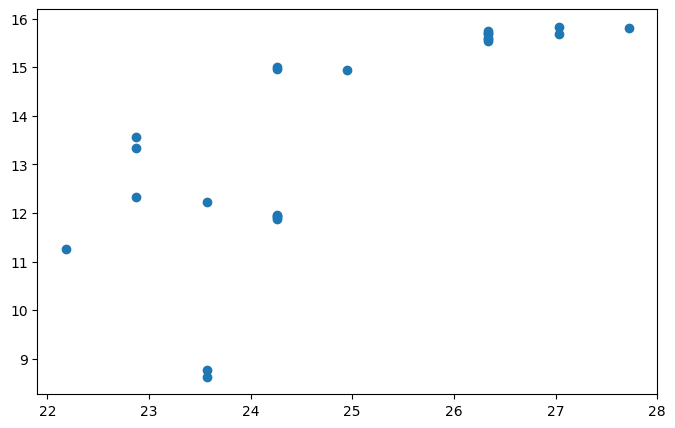

In [209]:
plt.figure(figsize=(8,5))
plt.plot(n_ops, flops, marker='o', linestyle='')
plt.show()